### Notebook:
<a>https://pennylane.ai/qml/demos/tutorial_quanvolution/<a/> 

In [2]:
!pip install pennylane-qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 35.9 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.0 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.7/339.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 55.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 32.9 MB/s eta 0:00

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-08-09 17:30:01.020056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 17:30:01.020215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 17:30:01.199187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 100    # Size of the train dataset
n_test = 30     # Size of the test dataset

In [6]:
SAVE_PATH = "/kaggle/input"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

import os
os.makedirs(SAVE_PATH, exist_ok = True) # creating a directory for SAVE_PATH.

## Import the MNIST dataset from Keras. 

In [7]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [9]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

## Define a function that convolves the input image

In [10]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset (not training quantum convolution layer)

In [11]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
100/100        
Quantum pre-processing of test images:


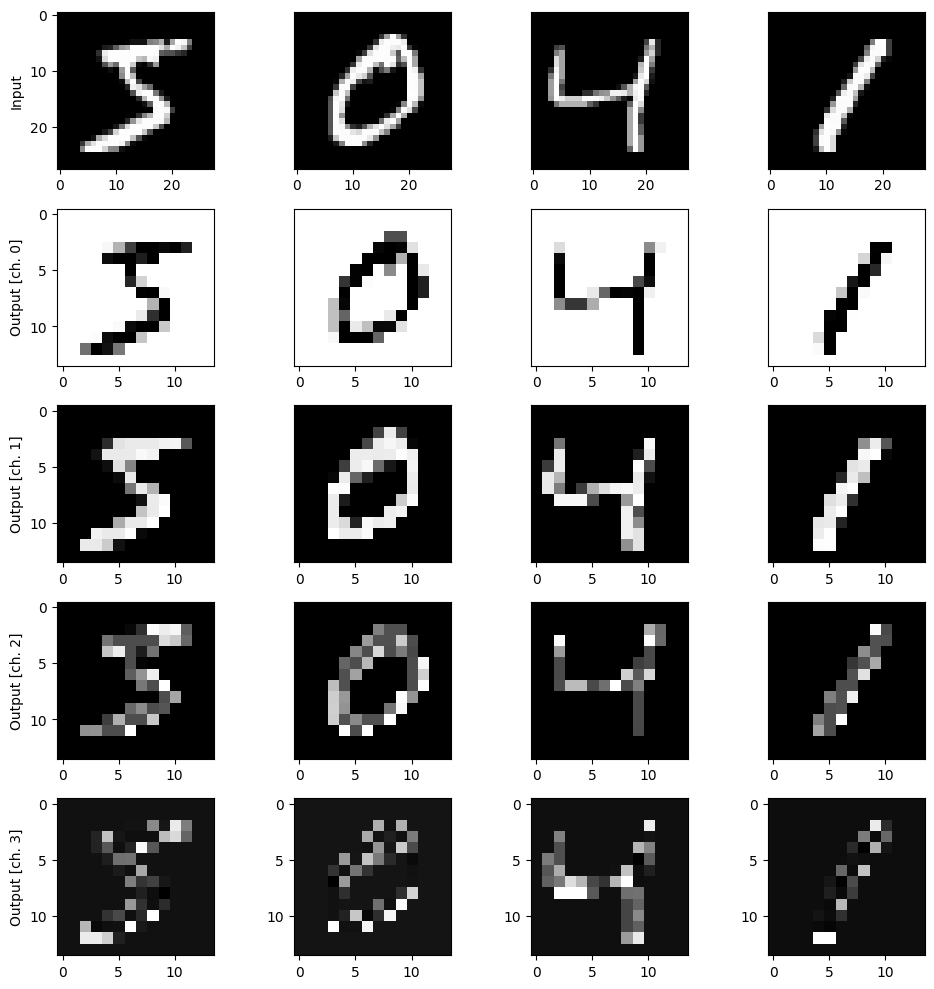

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [14]:
def Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [15]:
q_model = Model()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=10,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
10/10 - 1s - 125ms/step - accuracy: 0.0800 - loss: 2.5829 - val_accuracy: 0.1667 - val_loss: 2.2585
Epoch 2/30
10/10 - 0s - 6ms/step - accuracy: 0.2300 - loss: 1.9843 - val_accuracy: 0.3667 - val_loss: 2.0206
Epoch 3/30
10/10 - 0s - 6ms/step - accuracy: 0.5000 - loss: 1.6224 - val_accuracy: 0.4333 - val_loss: 1.8219
Epoch 4/30
10/10 - 0s - 6ms/step - accuracy: 0.7500 - loss: 1.3101 - val_accuracy: 0.4667 - val_loss: 1.6309
Epoch 5/30
10/10 - 0s - 6ms/step - accuracy: 0.8700 - loss: 1.0749 - val_accuracy: 0.6000 - val_loss: 1.5003
Epoch 6/30
10/10 - 0s - 6ms/step - accuracy: 0.9100 - loss: 0.9033 - val_accuracy: 0.6333 - val_loss: 1.4039
Epoch 7/30
10/10 - 0s - 6ms/step - accuracy: 0.9100 - loss: 0.7635 - val_accuracy: 0.7000 - val_loss: 1.3251
Epoch 8/30
10/10 - 0s - 6ms/step - accuracy: 0.9500 - loss: 0.6555 - val_accuracy: 0.7000 - val_loss: 1.2649
Epoch 9/30
10/10 - 0s - 6ms/step - accuracy: 0.9500 - loss: 0.5712 - val_accuracy: 0.7000 - val_loss: 1.2199
Epoch 10/30
10/10

## Make model without quantum convolution and compare

In [16]:
c_model = Model()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=10,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
10/10 - 1s - 84ms/step - accuracy: 0.2200 - loss: 2.2529 - val_accuracy: 0.3333 - val_loss: 2.1173
Epoch 2/30
10/10 - 0s - 7ms/step - accuracy: 0.4900 - loss: 1.8523 - val_accuracy: 0.6000 - val_loss: 1.8821
Epoch 3/30
10/10 - 0s - 7ms/step - accuracy: 0.6900 - loss: 1.5708 - val_accuracy: 0.6333 - val_loss: 1.7151
Epoch 4/30
10/10 - 0s - 7ms/step - accuracy: 0.8300 - loss: 1.3497 - val_accuracy: 0.6667 - val_loss: 1.5863
Epoch 5/30
10/10 - 0s - 7ms/step - accuracy: 0.8500 - loss: 1.1644 - val_accuracy: 0.7333 - val_loss: 1.4810
Epoch 6/30
10/10 - 0s - 14ms/step - accuracy: 0.9300 - loss: 1.0114 - val_accuracy: 0.7333 - val_loss: 1.3936
Epoch 7/30
10/10 - 0s - 8ms/step - accuracy: 0.9500 - loss: 0.8863 - val_accuracy: 0.7333 - val_loss: 1.3204
Epoch 8/30
10/10 - 0s - 7ms/step - accuracy: 0.9500 - loss: 0.7834 - val_accuracy: 0.7000 - val_loss: 1.2593
Epoch 9/30
10/10 - 0s - 7ms/step - accuracy: 0.9500 - loss: 0.6981 - val_accuracy: 0.7000 - val_loss: 1.2087
Epoch 10/30
10/10

/tmp/ipykernel_34/925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


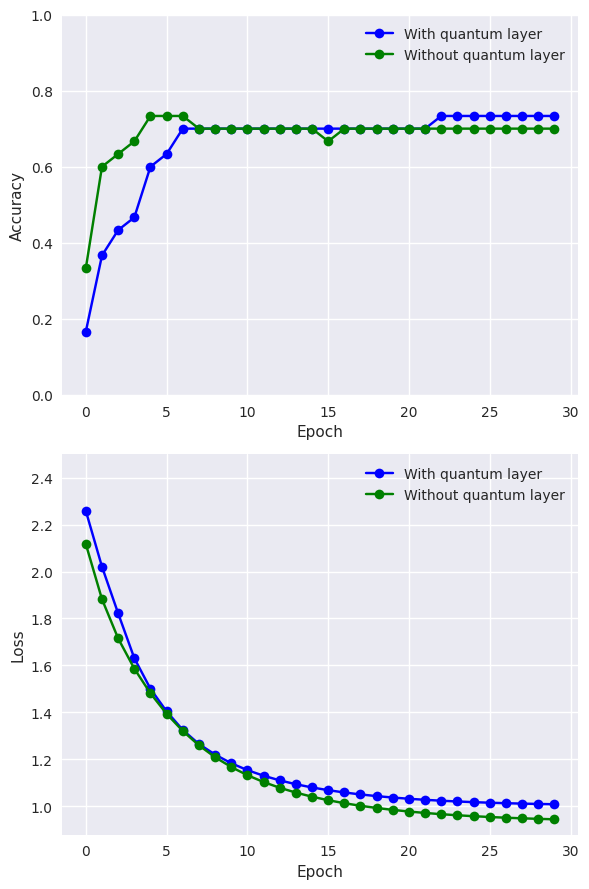

In [17]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()